# Final Project: Solving Edutech Company Problems

## Preparation

### Preparing the required libraries

In [1]:
import logging, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, missingno as msno, warnings, joblib

from tqdm import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')

# Configure logging to show INFO messages
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    force=True
)
logger = logging.getLogger(__name__)

# Attach a stdout handler explicitly
stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setLevel(logging.INFO)
logger.addHandler(stdout_handler)

# set random seed for reproducibility
RANDOM_STATE = 42

### Prepare the data to be used

In [2]:
academic_dataset = 'data.csv'

try:
  academic_df = pd.read_csv(academic_dataset, sep=';')

except FileNotFoundError:
  print(f"Error: File '{academic_dataset}' not found.")
except pd.errors.ParserError:
  print(f"Error: Could not parse the file '{academic_dataset}'. Check the file format and separator.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

## Data Understanding

### Basic Informations

This stage aims to find out basic information about the dataset.

In [3]:
academic_df

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [4]:
academic_df.shape

(4424, 37)

In [5]:
academic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

In [6]:
for column in academic_df.columns:
    print(f"Description of column '{column}':")
    print(academic_df[column].describe())
    print("-" * 20)

Description of column 'Marital_status':
count    4424.000000
mean        1.178571
std         0.605747
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: Marital_status, dtype: float64
--------------------
Description of column 'Application_mode':
count    4424.000000
mean       18.669078
std        17.484682
min         1.000000
25%         1.000000
50%        17.000000
75%        39.000000
max        57.000000
Name: Application_mode, dtype: float64
--------------------
Description of column 'Application_order':
count    4424.000000
mean        1.727848
std         1.313793
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: Application_order, dtype: float64
--------------------
Description of column 'Course':
count    4424.000000
mean     8856.642631
std      2063.566416
min        33.000000
25%      9085.000000
50%      9238.000000
75%      9556.000000
max      9991

### Distribution Categorical Features

This stage aims to see the distribution of categorical features.

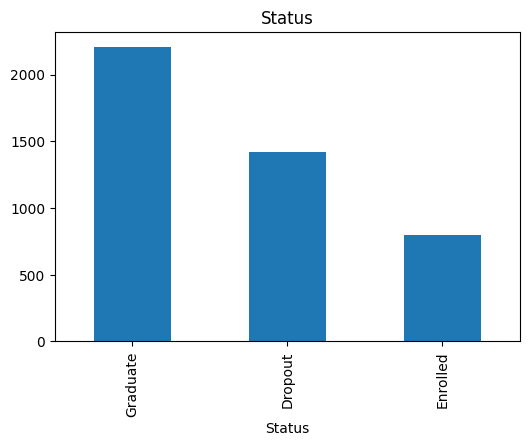

In [7]:
categorical_cols = academic_df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    academic_df[col].value_counts().plot(kind='bar')
    plt.title(col)

plt.tight_layout()
plt.show()

This stage aims to visualize the frequency and proportion of each level of categorical variables.

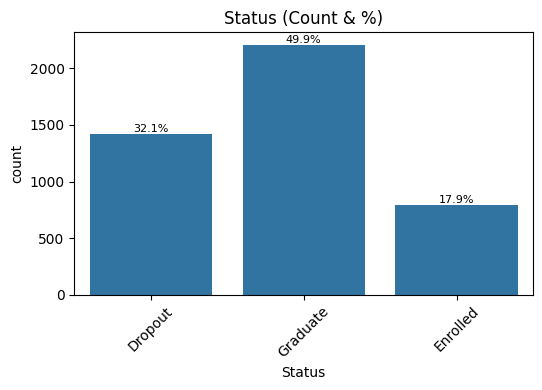

In [8]:
n_cat = len(categorical_cols)
n_cols = 3
n_rows = int(np.ceil(n_cat / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(x=col, data=academic_df, ax=ax)
    total = len(academic_df)
    for p in ax.patches:
        pct = f"{100 * p.get_height()/total:.1f}%"
        ax.annotate(pct, (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    ax.set_title(f"{col} (Count & %)")
    ax.tick_params(axis='x', rotation=45)

for ax in axes[n_cat:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Distribution Numerical Features

This stage aims to see the distribution of numerical features.

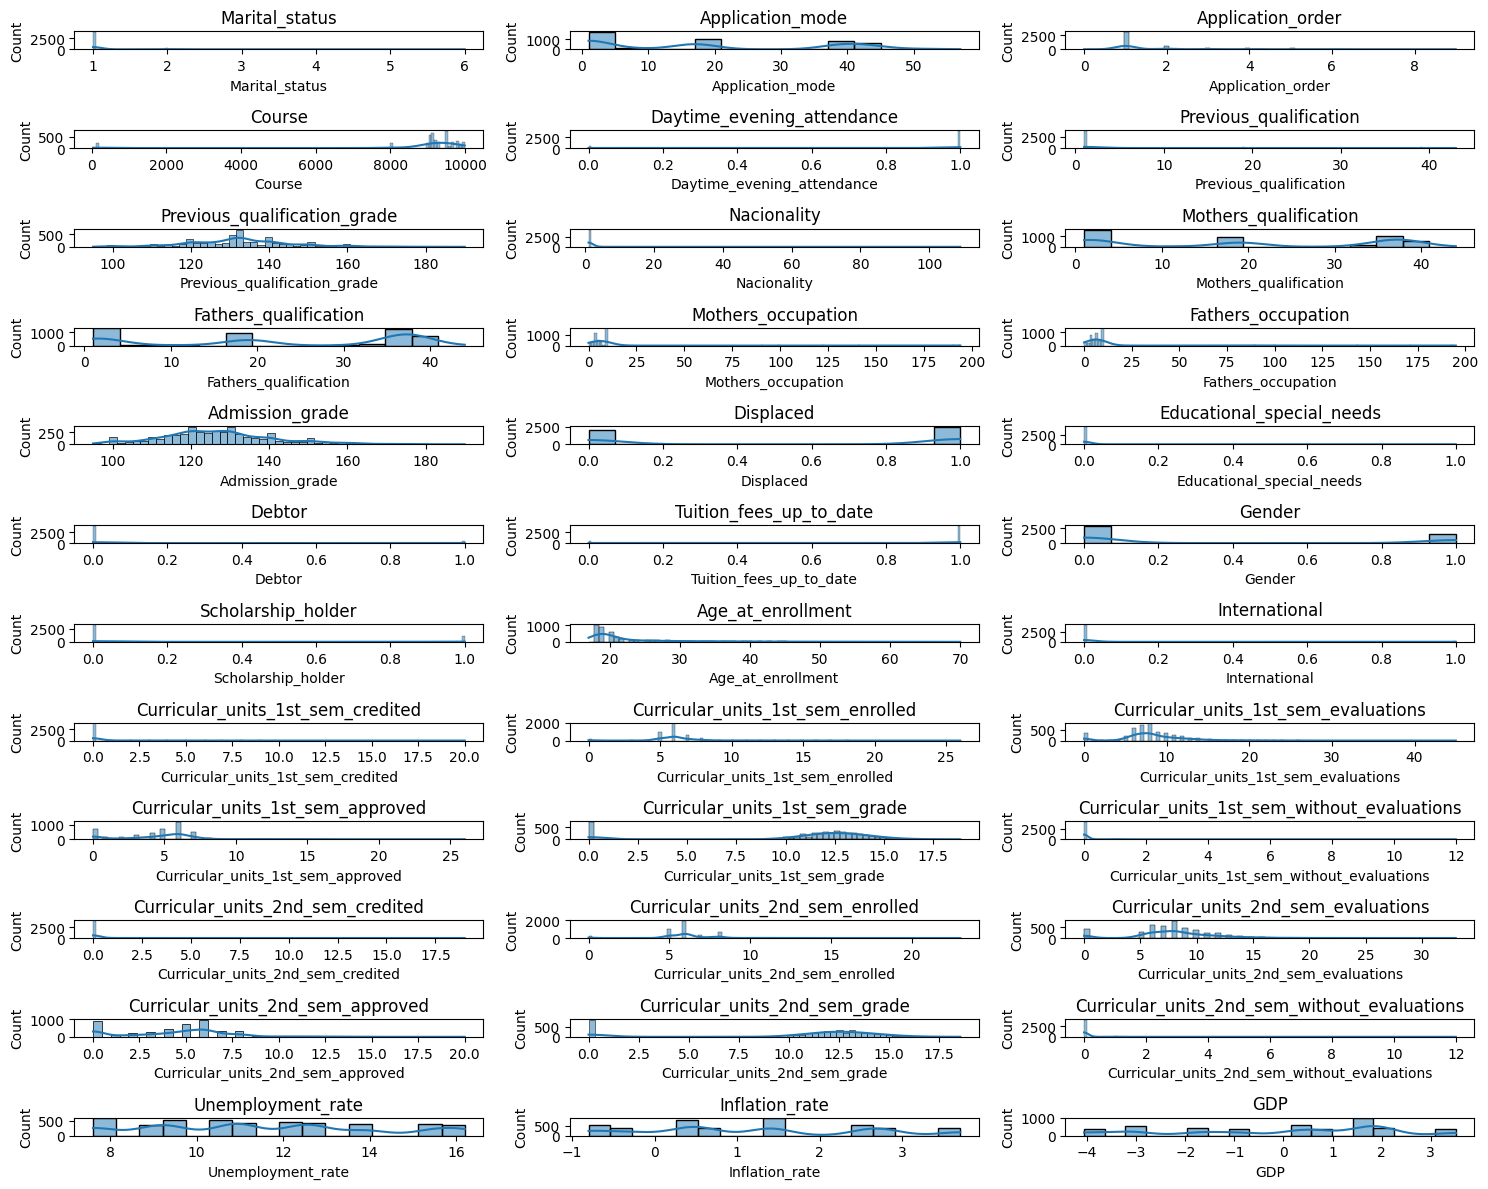

In [9]:
numerical_cols = academic_df.select_dtypes(include=np.number).columns

num_cols = 3
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(academic_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

Based on the distribution of each numeric variable, the following insights were obtained:
1. The majority of students are single (category "1"), with very few being married or previously married.
2. Most applicants choose the modern application mode (values "20-50" in Application_mode), and almost 90% apply on their first attempt (Application_order = 1).
3. The most popular courses are coded above 9,000, and almost all students are enrolled in the evening/daytime study program (Daytime_evening_attendance = 1).
4. Previous qualification grades (Previous_qualification_grade) are normally distributed around 130-140, but a significant number have only a basic qualification (Previous_qualification = 1-5).
5. Maternal and paternal education show two clusters: many have only completed primary school (12 years of qualification) or a university degree (36-40 years of schooling).
6. Only a small percentage (10%) of students are in arrears (Debtor = 1), and almost all pay their tuition fees on time (Tuition_fees_up_to_date = 1).
7. Scholarship recipients are a minority (<15%), and displaced students (migration) occupy two peaks: very few and almost all.
8. Gender distribution tends to be balanced, with a slight preponderance of females (Gender = 1), while international students are relatively few (<20%).
9. Semester Academic Activities
    - 1st semester: the average student takes 6 credits, with 5 credits approved, and the average grade is around 12–13
    - 2nd semester: a similar pattern, with a slightly higher load (7 credits). The average grade decreases slightly (11–12).
10. Unemployment rates range from 8–16%, inflation from 0–3%, and GDP growth from -4–4%, indicating varying economic conditions at the time of registration.

This stage aims to visualize the distribution and outliers on all numerical features at a glance.

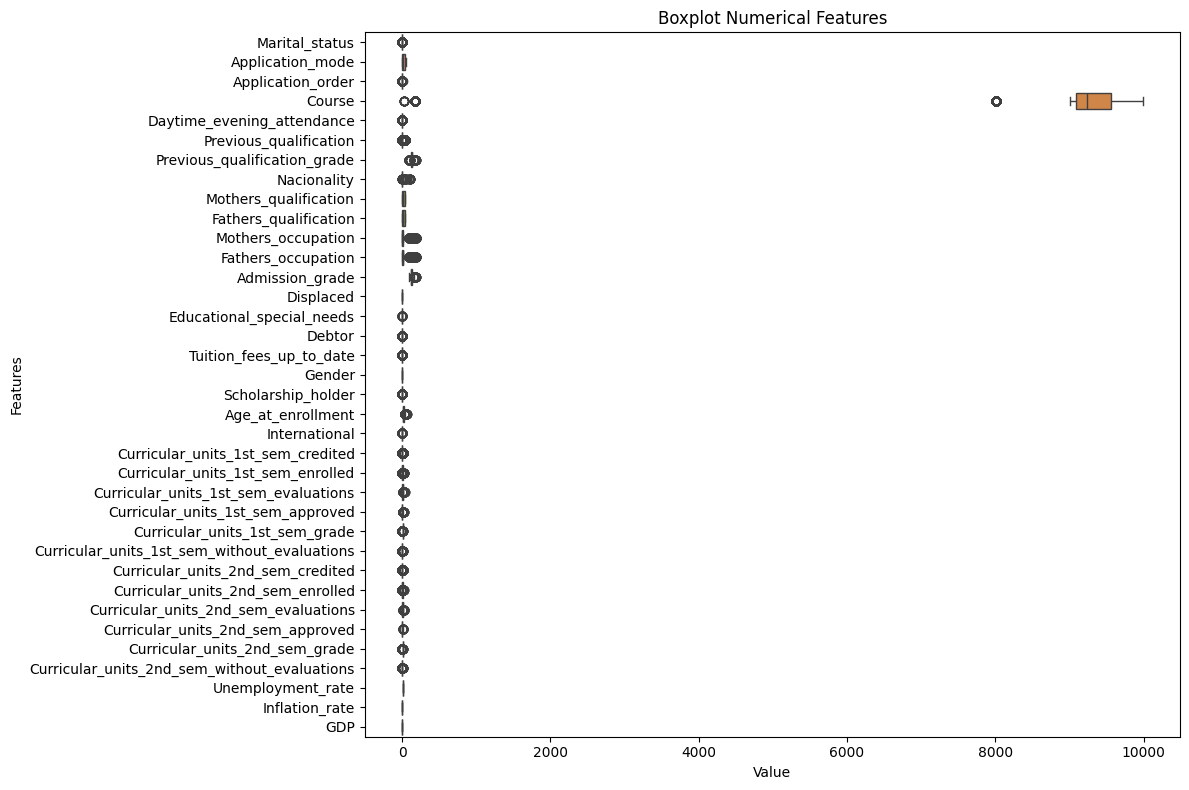

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=academic_df[numerical_cols], orient='h')
plt.title("Boxplot Numerical Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the boxplot distribution, here are some insights:
1. The values of the Course feature (credit numbers, hours, or course weight) are spread much more widely—around 8,000 to nearly 10,000—compared to all other features, which are clustered around 0–20. This indicates that the scale or unit of measurement for Course is very different and much larger, requiring normalization or standardization before modeling.
2. There are several outliers in the Course feature (below 8,000), indicating that some "course" values are significantly lower than the majority. This could be a case of short, intensive courses or unusual enrollment data.
3. Nearly all other numeric features (e.g., Age_at_enrollment, Curricular_units_1st_sem_credited, Unemployment_rate, etc.) range very narrowly near zero and show no significant outliers. This indicates the homogeneity of the distribution, or the uniformity of the values across these features.
4. Due to the extreme scale differences, pre-processing such as scaling (MinMaxScaler or StandardScaler) should be applied per feature so that the model is not “dominated” by the Course feature.

### Distribution Label

This stage aims to see the distribution of labels/targets.

In [11]:
status_dist = academic_df['Status'].value_counts(normalize=True) * 100
status_dist

Status
Graduate    49.932188
Dropout     32.120253
Enrolled    17.947559
Name: proportion, dtype: float64

### Numerical vs Status

This stage aims to see the differences in the distribution of key numerical features based on the target class.

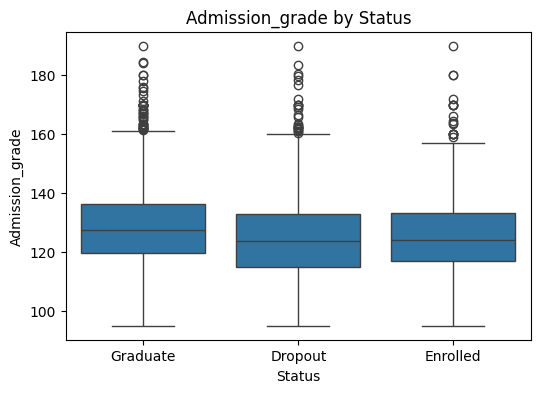

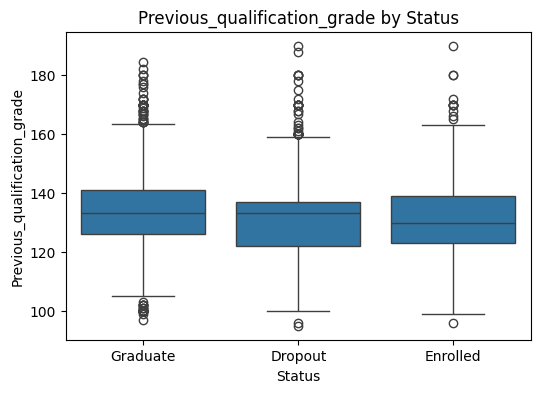

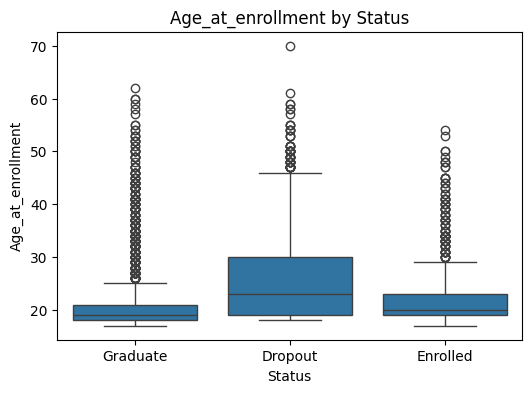

In [12]:
for col in ['Admission_grade','Previous_qualification_grade','Age_at_enrollment']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Status', y=col, data=academic_df, order=['Graduate','Dropout','Enrolled'])
    plt.title(f"{col} by Status")
    plt.show()

### Categorical vs Status

This stage aims to assess the distribution of targets in each level of categorical variables.

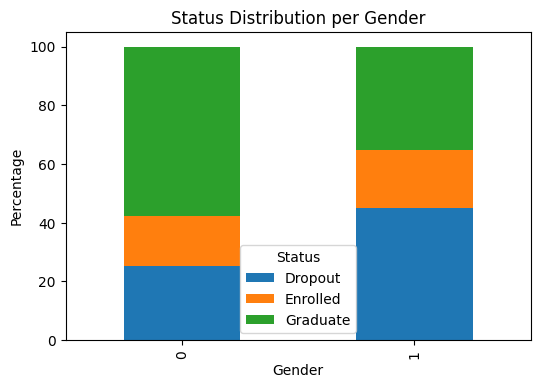

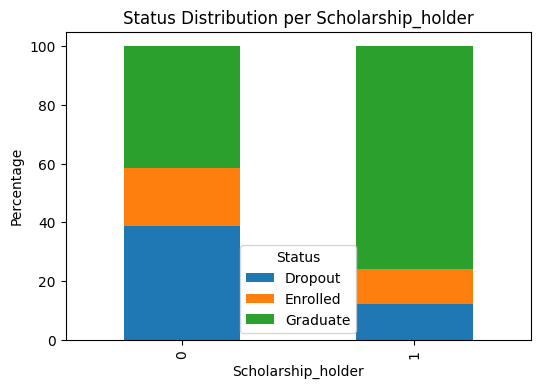

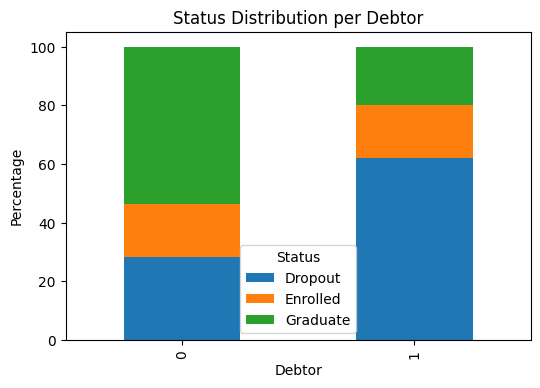

In [13]:
for col in ['Gender','Scholarship_holder','Debtor']:
    ct = pd.crosstab(academic_df[col], academic_df['Status'], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, figsize=(6,4))
    plt.ylabel("Percentage")
    plt.title(f"Status Distribution per {col}")
    plt.legend(title='Status')
    plt.show()

### Numerical Subset

This stage aims to explore pairwise relationships between selected numerical features, grouped by target.

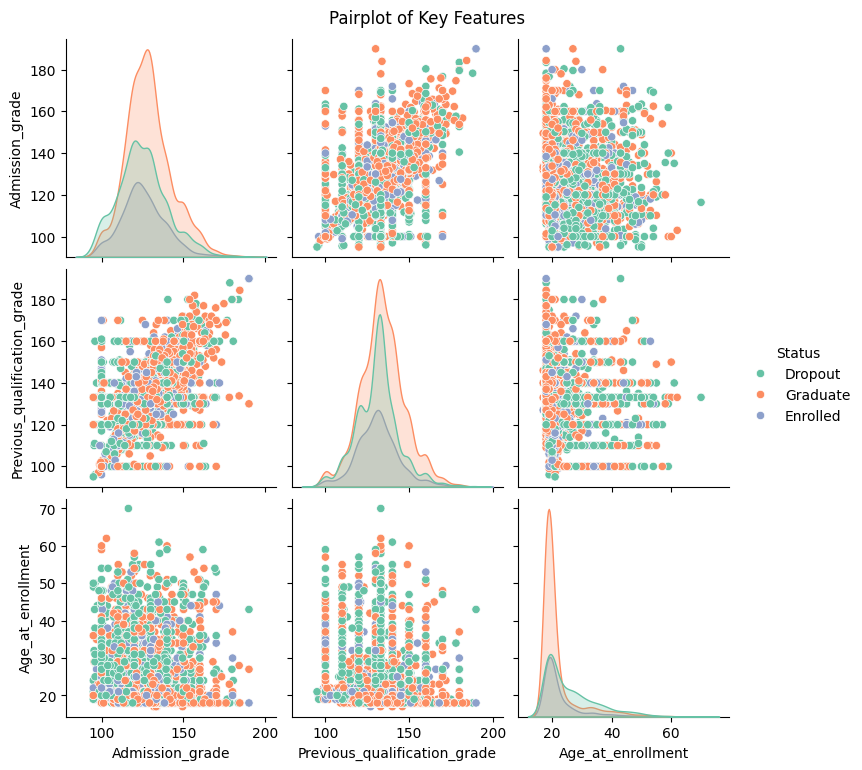

In [14]:
subset = ['Admission_grade','Previous_qualification_grade','Age_at_enrollment']
sns.pairplot(academic_df[subset + ['Status']], hue='Status', diag_kind='kde',
             vars=subset, palette='Set2')
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

Several insights can be drawn from the pairplot:
1. The dots spread upwards to the upper right in the scatterplot between Previous_qualification_grade and Admission_grade, indicating that students with high previous qualification scores tend to also achieve high admission scores.
2. In the Admission_grade and Previous_qualification_grade distributions (diagonal), the orange dots (Graduate) are clustered on the right side (high scores), while the green (Dropout) and blue (Enrolled) dots are more spread out to the left (lower scores). This indicates that higher academic scores are associated with a greater likelihood of graduation.
3. The Age_at_enrollment distribution is relatively similar for all three groups (Dropout, Graduate, Enrolled), peaking in the 20-25 age range. The scatterplot shows no strong trend that younger or older age is consistently correlated with either status.
4. In the Admission_grade range of 120–160 and Previous_qualification_grade range of 120–160, the three statuses are mixed, meaning that in the middle range, the status prediction (dropout vs. enrolled vs. graduate) is less clear without considering other features.
5. Because Admission_grade and Previous_qualification_grade are quite strong in separating graduates from dropouts/enrolled, derived features (e.g., the difference or average of the two) can help improve the performance of the classification model.

### Correlation for Numerical Features

This stage aims to see the correlation of numerical features.

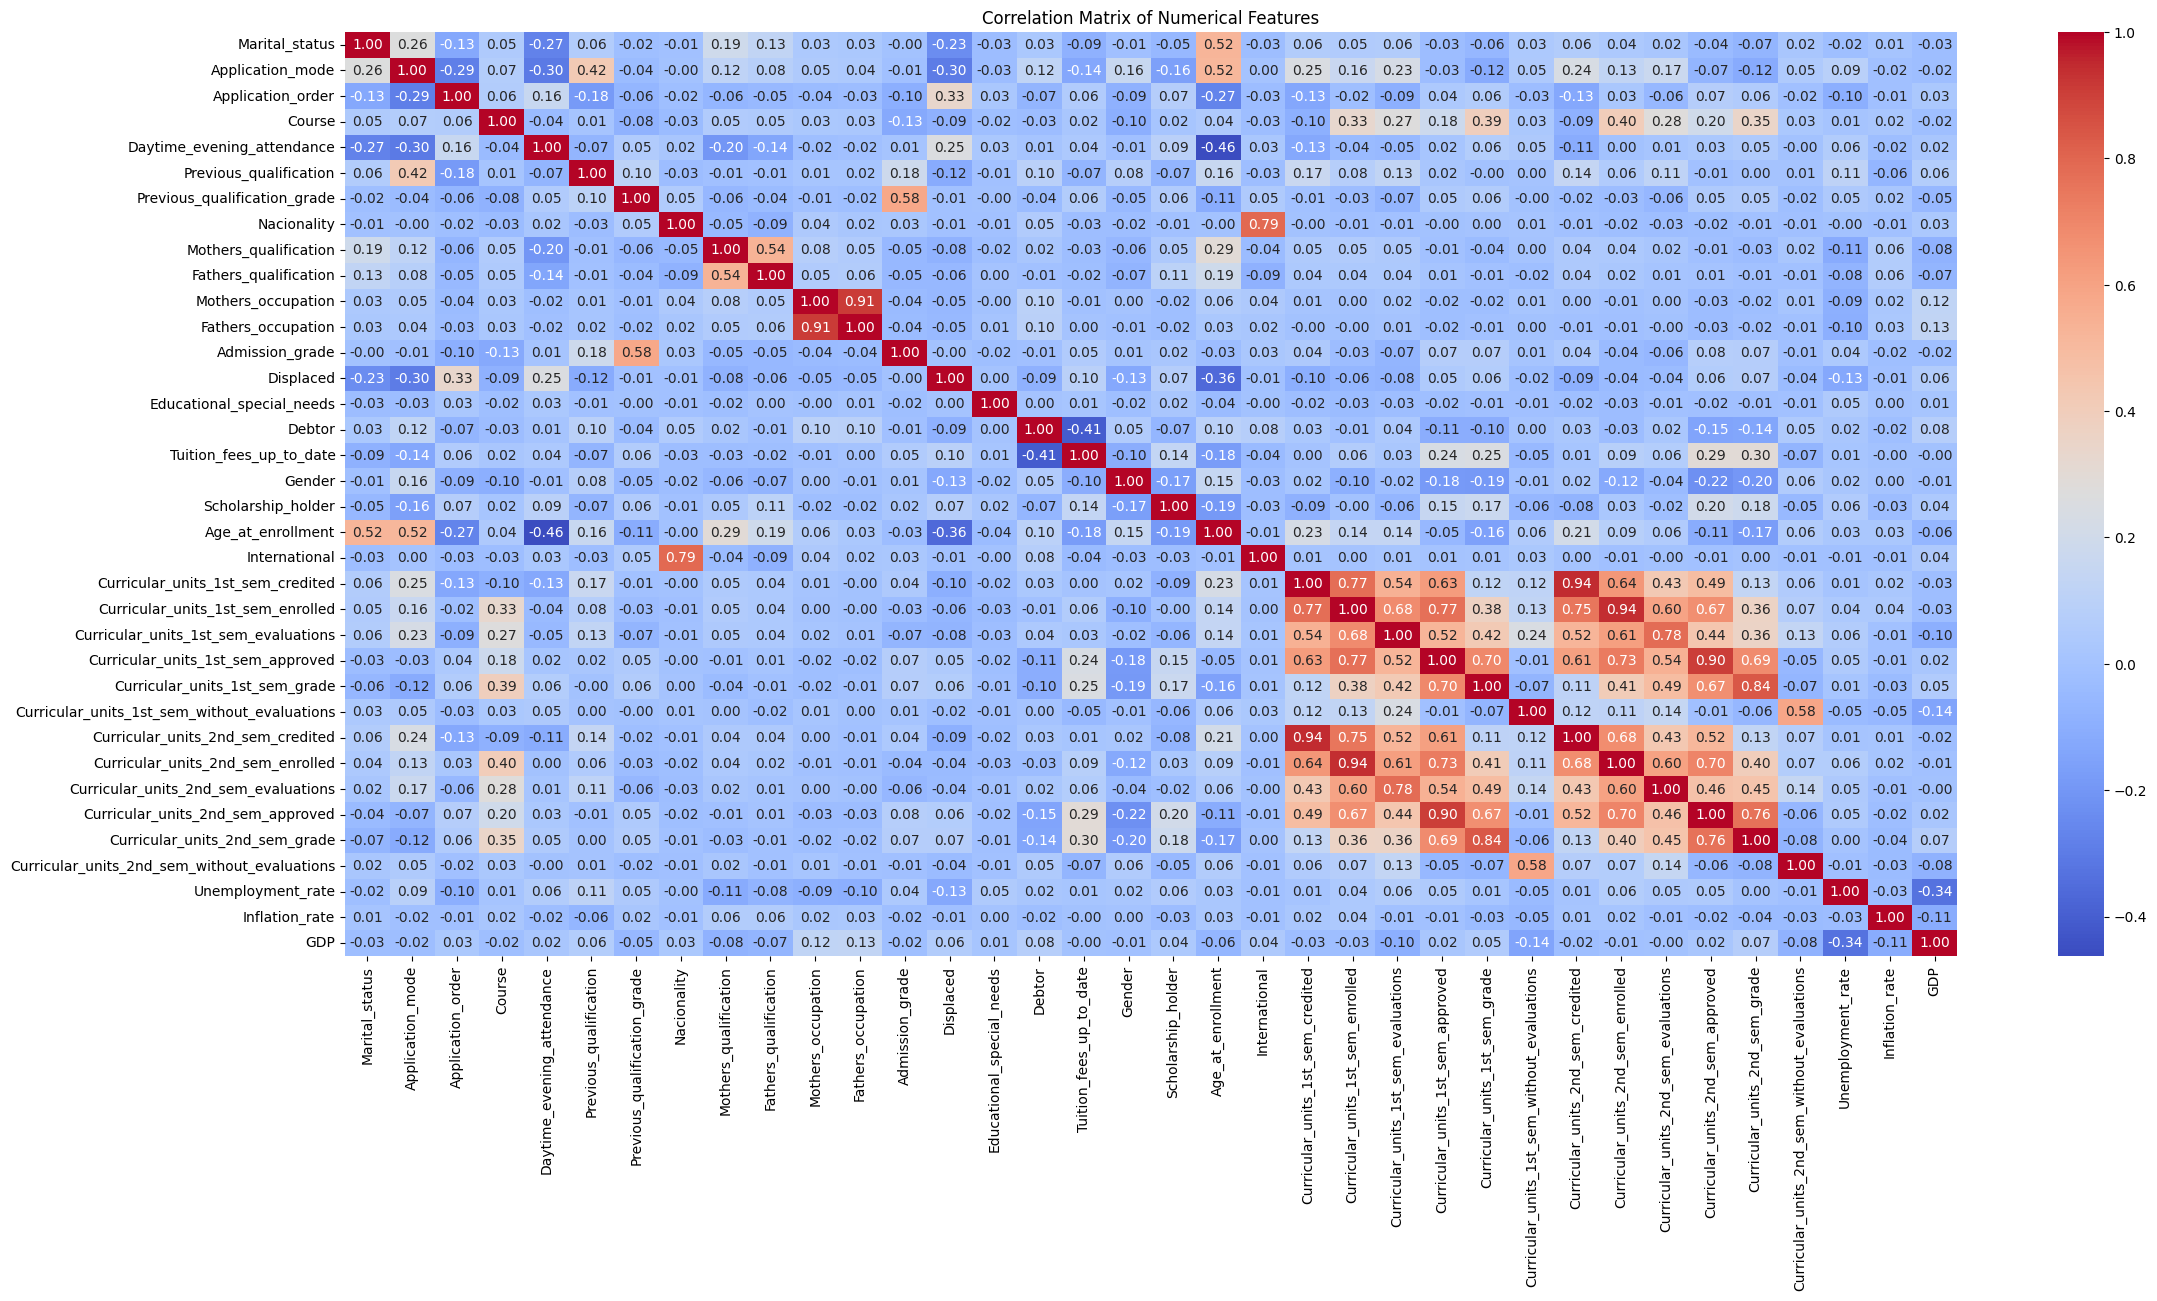

In [15]:
plt.figure(figsize=(26, 12))
sns.heatmap(academic_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### High Correlation

This stage aims to identify pairs of numerical features with high correlation (> 0.95).

In [16]:
corr = academic_df[numerical_cols].corr().abs()
high_corr = corr[(corr > 0.95) & (corr < 1.0)].stack().reset_index()
high_corr.columns = ['feat1','feat2','corr']

print("High correlations (> 0.95):")

high_corr.sort_values('corr', ascending=False).head()

High correlations (> 0.95):


,feat1,feat2,corr


### Statistic per Target Class

This stage aims to provide a summary of the mean and median for key numeric features per target class.

In [17]:
grouped = academic_df.groupby('Status')[['Admission_grade','Age_at_enrollment']].agg(['mean','median'])

print("Admission & Age Summary per Status:\n", grouped)

Admission & Age Summary per Status:
          Admission_grade        Age_at_enrollment       
                    mean median              mean median
Status                                                  
Dropout       124.961365  123.6         26.068966   23.0
Enrolled      125.534257  124.1         22.369018   20.0
Graduate      128.794432  127.4         21.783612   19.0


### Missing Data Pattern

This stage aims to display the pattern and intensity of missing data.

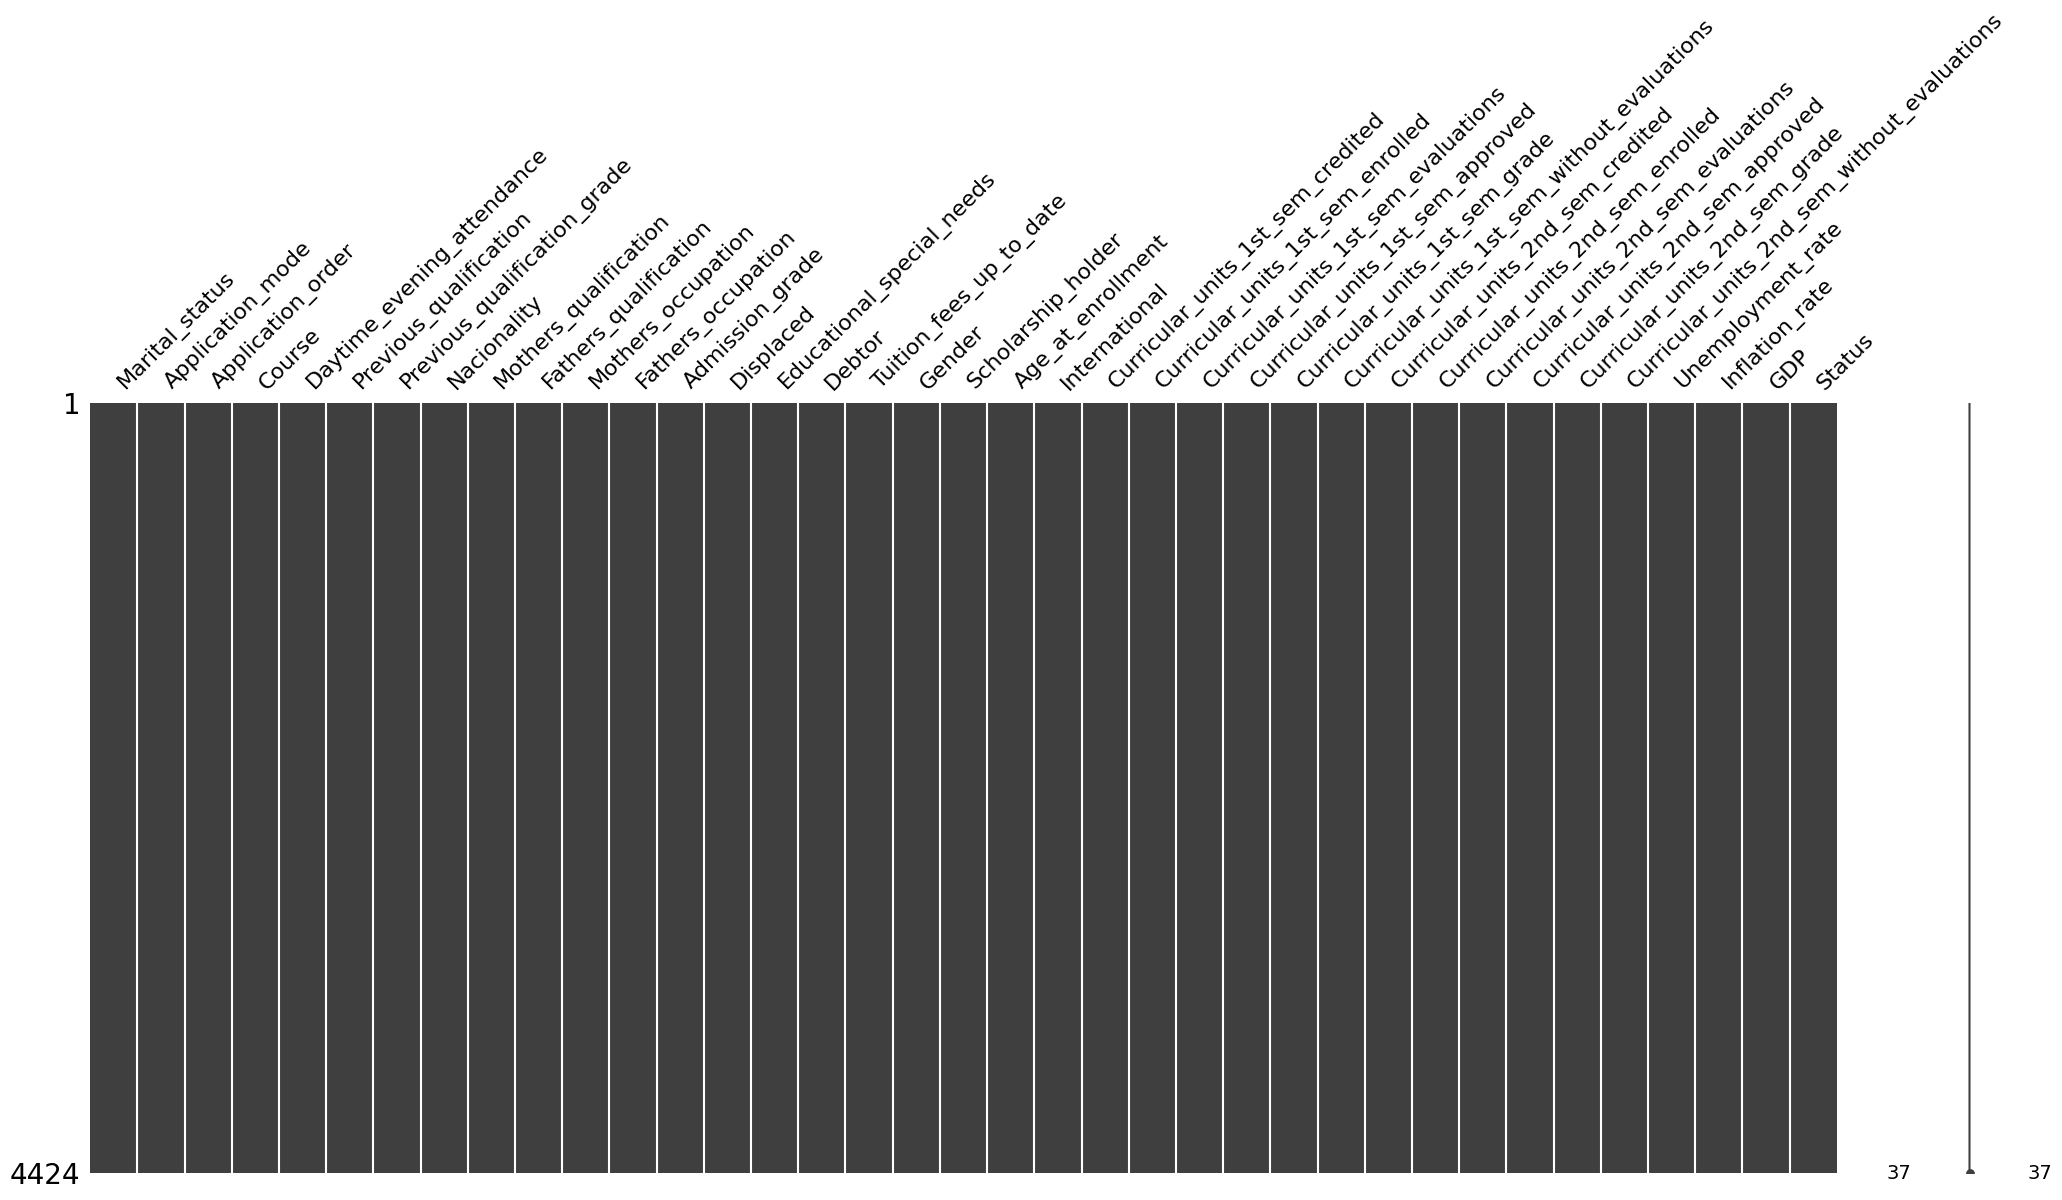

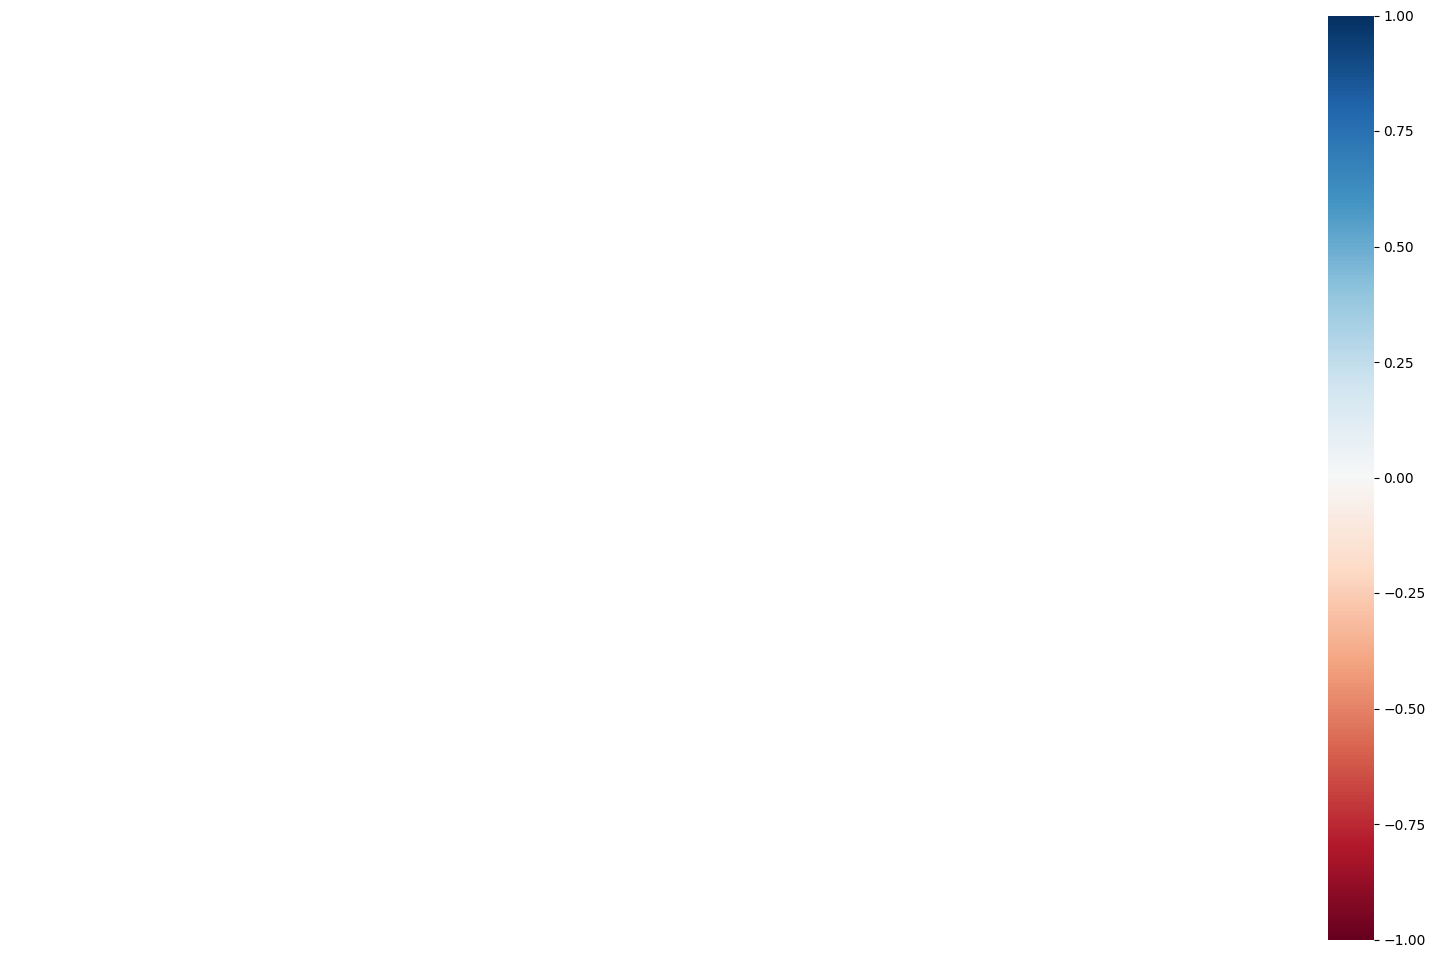

In [18]:
msno.matrix(academic_df)
plt.show()
msno.heatmap(academic_df)
plt.show()

### Check Missing Values

This stage aims to check for empty values.

In [19]:
rows_with_missing_values = academic_df[academic_df.isnull().any(axis=1)]
rows_with_missing_values

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status


### Check Outliers

This stage aims to check extreme values (outliers).

In [20]:
# Calculate IQR limits and return outlier DataFrame per column
def find_outliers_iqr(df, cols, factor=1.5):
    subset_df = df[cols]
    Q1 = subset_df.quantile(0.25)
    Q3 = subset_df.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR

    outlier_mask = ((df[cols] < lower) | (df[cols] > upper))

    return lower, upper, outlier_mask

def report_outliers(df, cols, outlier_mask):
    print("=== Outlier Report ===")

    for col in cols:
        mask_col = outlier_mask[col]
        n_out = mask_col.sum()

        print(f"{col:30s}: {n_out:4d} outliers")

        if n_out > 0:
            print("  contoh:", df.loc[mask_col, col].sort_values().unique()[:5])

    print("======================\n")

numerical_features = academic_df.select_dtypes(include=np.number)

lower_bound, upper_bound, mask_df = find_outliers_iqr(academic_df, numerical_features.columns, factor=1.5)
report_outliers(academic_df, numerical_features.columns, mask_df)

=== Outlier Report ===
Marital_status                :  505 outliers
  contoh: [2 3 4 5 6]
Application_mode              :    0 outliers
Application_order             :  541 outliers
  contoh: [4 5 6 9]
Course                        :  442 outliers
  contoh: [  33  171 8014]
Daytime_evening_attendance    :  483 outliers
  contoh: [0]
Previous_qualification        :  707 outliers
  contoh: [2 3 4 5 6]
Previous_qualification_grade  :  179 outliers
  contoh: [ 95.  96.  97.  99. 100.]
Nacionality                   :  110 outliers
  contoh: [ 2  6 11 13 14]
Mothers_qualification         :    0 outliers
Fathers_qualification         :    0 outliers
Mothers_occupation            :  182 outliers
  contoh: [ 90  99 122 123 125]
Fathers_occupation            :  177 outliers
  contoh: [ 90  99 101 102 103]
Admission_grade               :   86 outliers
  contoh: [160.4 160.5 160.6 161.  161.1]
Displaced                     :    0 outliers
Educational_special_needs     :   51 outliers
  contoh: [1

### Check Duplicates

This stage aims to check for data duplication.

In [21]:
duplicate_rows = academic_df[academic_df.duplicated()]

print(f"Number of duplicate rows: {len(duplicate_rows)}")
print("Duplicate rows:")

duplicate_rows

Number of duplicate rows: 0
Duplicate rows:


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status


## Data Preparation / Preprocessing

### Define Helper Functions & Custom Transformer

This stage aims to preprocess the data by addressing missing values, handling outliers, normalizing, converting data types, and applying encoding and feature selection, so that the data consisting of numeric, categorical, and boolean features is ready for use in the modeling process.

In [22]:
def cast_to_str(X):
  return X.astype(str)

def cast_to_int(X):
  return X.astype(int)

class IQROutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
      self.factor = factor

    def fit(self, X, y=None):
        q1 = np.percentile(X, 25, axis=0)
        q3 = np.percentile(X, 75, axis=0)
        iqr = q3 - q1

        self.lower_ = q1 - self.factor * iqr
        self.upper_ = q3 + self.factor * iqr

        return self

    def transform(self, X):
      return np.clip(X, self.lower_, self.upper_)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None

        if hasattr(input_features, '__len__') and not isinstance(input_features, str):
          return np.asarray(input_features, dtype=object)

        return np.asarray([input_features], dtype=object)

class FeatureNameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        return self.transformer.transform(X)

    def get_feature_names_out(self, input_features=None):
        if hasattr(self.transformer, 'get_feature_names_out'):
            return self.transformer.get_feature_names_out(input_features)
        elif input_features is not None:
            return input_features
        else:
            return None

def build_preprocessing_pipeline(df, target_col='Status_binary'):
    current_columns = df.columns

    bool_cols = [col for col in ['Displaced', 'Educational_special_needs',
                                 'Debtor', 'Tuition_fees_up_to_date', 'Gender',
                                 'Scholarship_holder', 'International']
                 if col in current_columns]

    cat_cols = [col for col in [
        'Marital_status', 'Application_mode', 'Application_order', 'Course',
        'Daytime_evening_attendance', 'Previous_qualification', 'Nacionality',
        'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation',
        'Fathers_occupation'] if col in current_columns]

    numeric_cols = [c for c in current_columns if c not in bool_cols +
                    cat_cols + [target_col, 'Status']]

    numeric_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy='median')),
        ('outlier',IQROutlierClipper()),
        ('scaler',StandardScaler()),
        ('var',VarianceThreshold())
    ])

    categorical_pipeline = Pipeline([
        ('to_str', FeatureNameTransformer(FunctionTransformer(cast_to_str))),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    bool_pipeline=Pipeline([
        ('cast',FeatureNameTransformer(FunctionTransformer(cast_to_int)))
    ])

    return ColumnTransformer([
        ('num',numeric_pipeline,numeric_cols),
        ('cat',categorical_pipeline,cat_cols),
        ('boo',bool_pipeline,bool_cols)
    ], remainder='drop')

### Drop Highly Correlated Features (>|0.95|)

This stage aims to remove numerical features that have very high correlation (above 0.95) in order to reduce redundancy and potential multicollinearity in the data before modeling is carried out.

In [23]:
num_df = academic_df.select_dtypes(include=[np.number])

corr = num_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]

logger.info(f"Dropping features with correlation > 0.95: {to_drop}")

academic_df = academic_df.drop(columns=to_drop)
academic_df

Dropping features with correlation > 0.95: []


2025-07-27 22:25:50,599 - __main__ - INFO - Dropping features with correlation > 0.95: []


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


### Binary Target

This stage aims to convert the target variable 'Status' into the binary format 'Status_binary' to facilitate the classification process in modeling.

In [24]:
academic_df['Status_binary'] = academic_df['Status'].map(lambda x: 1 if x=='Dropout' else 0)

logger.info("Converted Status to binary target Status_binary.")

academic_df

Converted Status to binary target Status_binary.


2025-07-27 22:25:50,646 - __main__ - INFO - Converted Status to binary target Status_binary.


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status,Status_binary
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,0


### Save Cleaned Dataset

This stage aims to save the cleaned dataset.

In [25]:
cleaned_df = academic_df.copy()

cleaned_df.to_csv('cleaned_students.csv', index=False)

logger.info("Saved cleaned dataset to cleaned_students.csv")

Saved cleaned dataset to cleaned_students.csv


2025-07-27 22:25:50,764 - __main__ - INFO - Saved cleaned dataset to cleaned_students.csv


### Load Cleaned Dataset

This stage aims to load the dataset that has been cleaned previously.

In [26]:
try:
    cleaned_df = pd.read_csv('cleaned_students.csv')

    logger.info("Loaded cleaned dataset from cleaned_students.csv")
except FileNotFoundError:
    logger.error("Error: cleaned_students.csv not found. Please run the data cleaning steps first.")

    cleaned_df = None

Loaded cleaned dataset from cleaned_students.csv


2025-07-27 22:25:50,815 - __main__ - INFO - Loaded cleaned dataset from cleaned_students.csv


In [27]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

### Split Data

This stage aims to divide the data into training, validation, and test data in a stratified manner against the target variable, ensuring that the proportion of classes remains balanced in each subset and supporting more accurate model evaluation.

In [28]:
X = cleaned_df.drop(['Status','Status_binary'], axis=1)
y = cleaned_df['Status_binary']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = RANDOM_STATE)

logger.info(f"Data split into train ({X_train.shape}), val ({X_val.shape}), test ({X_test.shape})")

Data split into train ((3096, 36)), val ((664, 36)), test ((664, 36))


2025-07-27 22:25:50,876 - __main__ - INFO - Data split into train ((3096, 36)), val ((664, 36)), test ((664, 36))


## Modeling

This stage aims to build a modeling pipeline with several classification algorithms, apply preprocessing consistently, and evaluate the initial performance of the model using AUC scores on validation data, comparing the effectiveness of each model.

In [29]:
preprocessor=build_preprocessing_pipeline(cleaned_df)

models={
    'LogisticRegression': LogisticRegression(class_weight = 'balanced',max_iter = 1000, random_state = RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(class_weight = 'balanced', random_state = RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state = RANDOM_STATE),
    'RandomForest': RandomForestClassifier(class_weight = 'balanced', n_estimators = 100, random_state = RANDOM_STATE),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = RANDOM_STATE),
    'LightGBM': LGBMClassifier(class_weight = 'balanced', random_state = RANDOM_STATE),
    'MLP': MLPClassifier(max_iter = 500, random_state = RANDOM_STATE)
}

results={}

for name, clf in tqdm(models.items(), desc = 'Model Loop'):
    pipe = Pipeline([('prep', preprocessor),('clf', clf)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, proba)
    results[name] = auc

    logger.info(f"{name} Validation AUC: {auc:.4f}")

print("Validation AUC comparison:",results)

Model Loop:   0%|          | 0/8 [00:00<?, ?it/s]

LogisticRegression Validation AUC: 0.9225


2025-07-27 22:25:51,135 - __main__ - INFO - LogisticRegression Validation AUC: 0.9225
Model Loop:  12%|█▎        | 1/8 [00:00<00:01,  4.44it/s]

DecisionTree Validation AUC: 0.7870


2025-07-27 22:25:51,313 - __main__ - INFO - DecisionTree Validation AUC: 0.7870
Model Loop:  25%|██▌       | 2/8 [00:00<00:01,  5.08it/s]

KNN Validation AUC: 0.8385


2025-07-27 22:25:54,898 - __main__ - INFO - KNN Validation AUC: 0.8385
Model Loop:  38%|███▊      | 3/8 [00:03<00:08,  1.74s/it]

GradientBoosting Validation AUC: 0.9278


2025-07-27 22:25:57,325 - __main__ - INFO - GradientBoosting Validation AUC: 0.9278
Model Loop:  50%|█████     | 4/8 [00:06<00:08,  2.01s/it]

RandomForest Validation AUC: 0.9273


2025-07-27 22:25:58,039 - __main__ - INFO - RandomForest Validation AUC: 0.9273
Model Loop:  62%|██████▎   | 5/8 [00:07<00:04,  1.54s/it]

XGBoost Validation AUC: 0.9074


2025-07-27 22:25:58,438 - __main__ - INFO - XGBoost Validation AUC: 0.9074
Model Loop:  75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 994, number of negative: 2102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM Validation AUC: 0.9218


2025-07-27 22:25:58,691 - __main__ - INFO - LightGBM Validation AUC: 0.9218
Model Loop:  88%|████████▊ | 7/8 [00:07<00:00,  1.16it/s]

MLP Validation AUC: 0.8910


2025-07-27 22:26:08,012 - __main__ - INFO - MLP Validation AUC: 0.8910
Model Loop: 100%|██████████| 8/8 [00:17<00:00,  2.14s/it]

Validation AUC comparison: {'LogisticRegression': 0.9225233644859814, 'DecisionTree': 0.7870197300103843, 'KNN': 0.8384631360332295, 'GradientBoosting': 0.9278296988577363, 'RandomForest': 0.9272637590861891, 'XGBoost': 0.9073624091381102, 'LightGBM': 0.9217549325025962, 'MLP': 0.8910384215991691}


## Evaluation

### Select Best & Test Evaluation

This stage aims to select the model with the best performance based on the AUC score on the validation data, then retrain the model and evaluate it on the test data using the AUC metrics, classification report, and confusion matrix to assess the model's generalization ability to new data.

In [30]:
best_name = max(results, key = results.get); best_model = Pipeline([('prep', preprocessor), ('clf', models[best_name])])
best_model.fit(X_train, y_train)
proba_test = best_model.predict_proba(X_test)[:, 1]; pred_test = best_model.predict(X_test)

print(f"Best model: {best_name}")
print(classification_report(y_test, pred_test, target_names = ['Non-Dropout', 'Dropout']))
print('Test AUC:', roc_auc_score(y_test, proba_test))
print('Confusion Matrix:\n', confusion_matrix(y_test, pred_test))

Best model: GradientBoosting
              precision    recall  f1-score   support

 Non-Dropout       0.90      0.94      0.92       451
     Dropout       0.86      0.78      0.82       213

    accuracy                           0.89       664
   macro avg       0.88      0.86      0.87       664
weighted avg       0.89      0.89      0.89       664

Test AUC: 0.9378688985353362
Confusion Matrix:
 [[424  27]
 [ 46 167]]


### Threshold Tuning & PR Curve

This stage aims to determine the best probabilistic prediction threshold based on the F1 score on the validation data, so as to optimize the balance between precision and recall in dropout classification.

In [31]:
proba_val = best_model.predict_proba(X_val)[:, 1]
thresh_range = np.linspace(0.1, 0.9, 50)
metrics = []

for t in thresh_range:
    pred_t = (proba_val >= t).astype(int)
    p = precision_score(y_val, pred_t)
    r = recall_score(y_val, pred_t)
    f1 = f1_score(y_val, pred_t)
    metrics.append((t, p, r, f1))

best_thresh = max(metrics, key=lambda x: x[3])[0]

logger.info(f"Best threshold by F1: {best_thresh:.2f}")

Best threshold by F1: 0.38


2025-07-27 22:26:10,694 - __main__ - INFO - Best threshold by F1: 0.38


### Plot PR Curve

This stage aims to describe the precision-recall (PR) curve on the validation data, assessing the trade-off between precision and recall at various prediction thresholds.

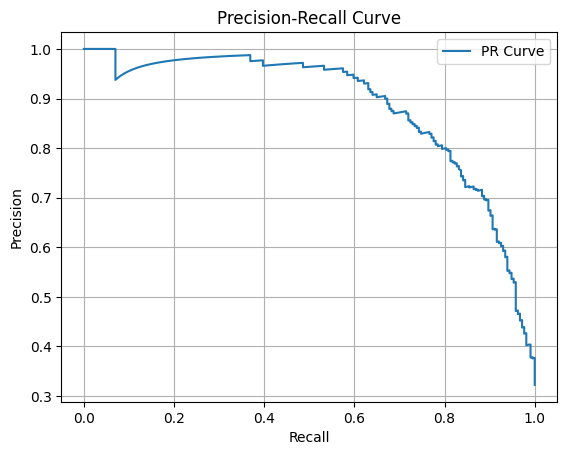

In [32]:
prec, rec, _ = precision_recall_curve(y_val, proba_val)
plt.plot(rec, prec, label='PR Curve')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.grid(True)
plt.show()

### Apply Best Threshold to Test Set

This stage aims to evaluate the model using an adjusted threshold (based on the F1 score) on the test data, by displaying a classification report and confusion matrix to assess the model's performance at the optimized threshold.

In [33]:
pred_test_thresh = (proba_test >= best_thresh).astype(int)

print("Evaluation at Tuned Threshold:")
print(classification_report(y_test, pred_test_thresh, target_names=['Non-Dropout','Dropout']))
print("Confusion Matrix at Tuned Threshold:\n", confusion_matrix(y_test, pred_test_thresh))

Evaluation at Tuned Threshold:
              precision    recall  f1-score   support

 Non-Dropout       0.92      0.89      0.90       451
     Dropout       0.78      0.83      0.80       213

    accuracy                           0.87       664
   macro avg       0.85      0.86      0.85       664
weighted avg       0.87      0.87      0.87       664

Confusion Matrix at Tuned Threshold:
 [[401  50]
 [ 36 177]]


### Choose Top 10 Feature Importance

This stage aims to evaluate the importance of features in the model by accessing the feature importances value, displaying the 10 most important features based on their contribution to the model.

In [34]:
importances = best_model.named_steps['clf'].feature_importances_
feature_names = best_model.named_steps['prep'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_10_features = importance_df.sort_values('Importance', ascending=False).head(10)
top_10_features

,Feature,Importance
9,num__Curricular_units_2nd_sem_approved,0.548997
230,boo__Tuition_fees_up_to_date,0.116727
5,num__Curricular_units_1st_sem_approved,0.053341
45,cat__Course_171,0.041195
10,num__Curricular_units_2nd_sem_grade,0.040803
2,num__Age_at_enrollment,0.033874
7,num__Curricular_units_2nd_sem_enrolled,0.014796
8,num__Curricular_units_2nd_sem_evaluations,0.011292
3,num__Curricular_units_1st_sem_enrolled,0.010772
229,boo__Debtor,0.010348


### Plot Top 10 Feature Importance

This stage aims to visualize the 10 most important features using a bar plot, thus making it easier to understand the contribution of each feature in the model.

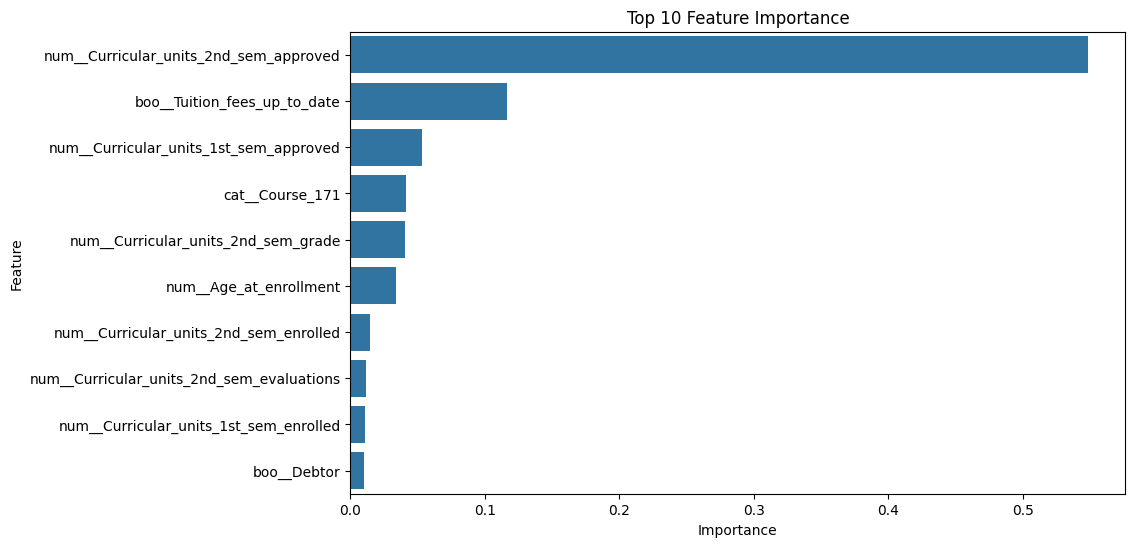

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = top_10_features)
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph provides insights:
- The number of courses completed ("approved") in the second semester is the most influential in predicting dropout. The fewer units approved, the higher the risk of dropout.
- On-time tuition payment status; those in arrears are at greater risk of dropping out.
- Initial performance influences study continuation.
- Students in certain programs/courses (code 171) exhibit different dropout behaviors, perhaps due to inadequate curriculum or support.
- Grades in the second semester also influence this; lower grades indicate a higher risk.
- Age at entry; older/younger students may face different challenges.
- The number of units enrolled in the second semester reflects the study load.
- The number of assessments in the second semester may be related to the frequency of feedback from lecturers.
- The study load in the first semester also has an effect, albeit to a lesser extent.
- Debt status: although less important than "fees up to date," it still indicates a crucial financial aspect.

**Conclusion**
- Semester 2 Academics Most Crucial
- All metrics related to semester 2 (approved units, grades, enrolled units, evaluations) occupy the majority of the top positions. This means that student performance and participation in semester 2 are the strongest indicators for predicting dropout.
- Financial Aspects Influential
- “Tuition_fees_up_to_date” and “Debtor” indicate that problems paying tuition fees increase the risk of dropout.
- Initial Achievement and Demographics
- Units approved in semester 1 and age at enrollment also contribute, albeit to a lesser extent. This suggests the importance of support from the start (semester 1) and potential differences in needs based on age.
- Program Specifics (Course_171)
- One study program (Course 171) exhibits unique dropout characteristics, requiring a review of its curriculum and support.

**Recommended Actions**
- Intensive Monitoring in Semester 2
- Provide additional academic mentoring, especially in semester 2, for students with a low number of approved units or declining grades.
- Financial Intervention
- Identify and assist students with outstanding fees, for example through scholarships, installments, or financial counseling.
- Early Support
- Orientation and tutoring programs in semester 1 to increase the number of approved units early on.
- Course 171 Program Audit
- Investigate the causes of the high dropout rate in Course 171, including the curriculum, assignment load, or supporting facilities.
- Age-Appropriate Approach
- Tailor services (e.g., time management workshops) based on age group, as age at enrollment also influences outcomes.

## Save Model

This stage aims to save the best model.

In [36]:
out_path='best_dropout_model.joblib'

joblib.dump(best_model,out_path)

print('Saved best model (',best_name,') to',out_path)

Saved best model ( GradientBoosting ) to best_dropout_model.joblib
